### Import

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import torch
from chronos import BaseChronosPipeline

##  Electricity Consumption Dataset Overview

The dataset contains hourly electricity consumption data collected over multiple years, comprising a total of approximately 54,000+ records.

Each record includes the following fields:

**Timestamp**: The date and time of the observation (with hourly frequency)
**Consumption**: The volume of electricity consumed (in kilowatt-hours or relevant unit) at that timestamp


## Loading the dataset

In [3]:
df = pd.read_csv('./data/electricity_consumption_and_production.csv', parse_dates=['DateTime'])
df = df.sort_values('DateTime')
df.set_index('DateTime', inplace=True)
df = df[['Consumption']]   
df.head()

,Consumption
DateTime,
2019-01-01 00:00:00,6352
2019-01-01 01:00:00,6116
2019-01-01 02:00:00,5873
2019-01-01 03:00:00,5682
2019-01-01 04:00:00,5557


In [48]:
len(df)

54161

In [ ]:
print(f"Total missing values of the target variable: {df.isna().sum()}")

Total missing values of the target variable: Consumption    0
dtype: int64


### EDA: Analyze trend, seasonality, cyclicity, residual. Check for stationarity

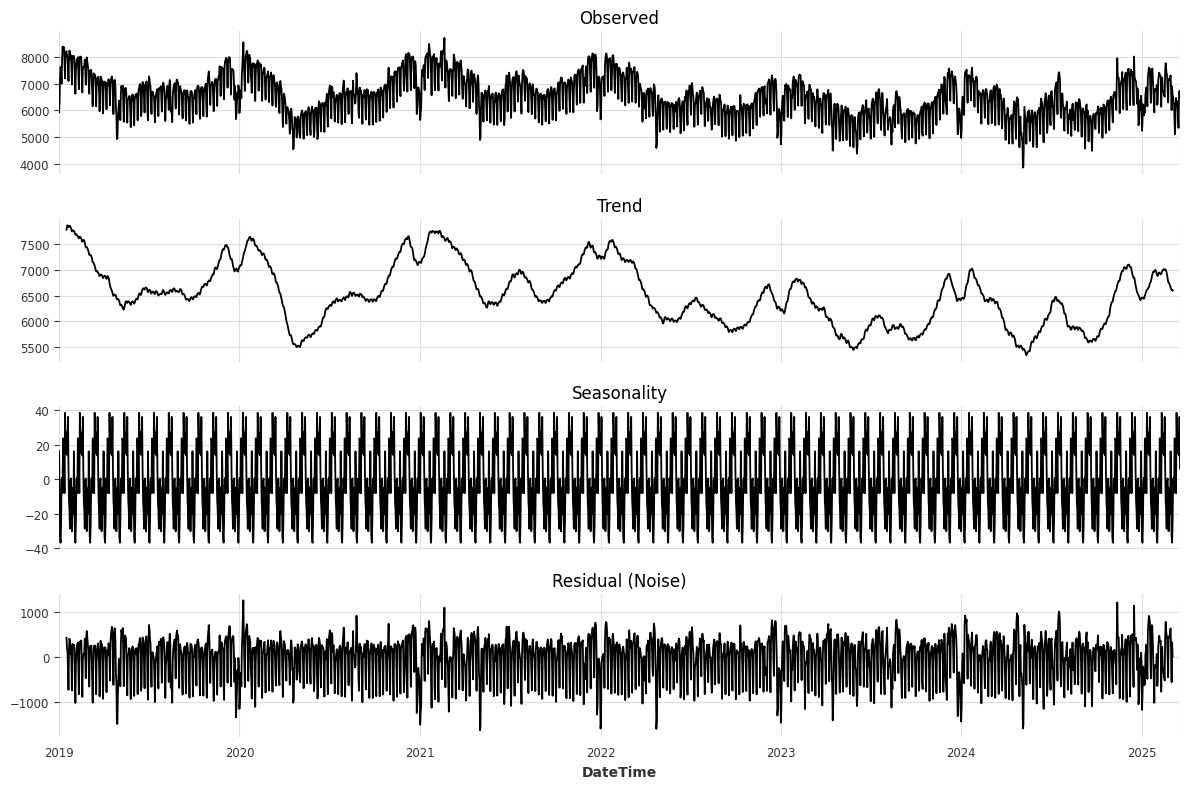

In [ ]:
daily_df = df["Consumption"].resample("D").mean().interpolate(method="linear")

decomposition = seasonal_decompose(daily_df, model="additive", period=30) 

# Visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residual (Noise)')
plt.tight_layout()
plt.show()


###  **Daily Decomposition of Electricity Consumption in Romania**

* **Observed**: The original daily average electricity consumption, showing regular short-term fluctuations and long-term seasonal cycles.
* **Trend**: The smoothed underlying trend. A gradual decline in daily consumption is visible after peaks in 2021 and 2023.
* **Seasonality**: Strong **weekly seasonal structure** — electricity consumption dips during weekends and rises on weekdays, repeated every 7 days.
* **Residual (Noise)**: The remaining irregularities, indicating unexpected spikes or drops possibly caused by holidays, temperature anomalies, or measurement noise.



### __Check for stationarity__
In order to ensure a time series is stationary, we can use a statisitcal test, for example, the Dickey-Fuller, which is the most popular one. This test checks for the presence of a unit root, which indicates non-stationarity.

- If __p-value__ < 0.05 → reject __H₀__ → likely stationary
- If __p-value__ ≥ 0.05 → fail to reject __H₀__ → likely non-stationary

In [8]:
def adf_stationarity_test(time_series: pd.Series):
    """Checks if time series is stationary based on ADF test"""

    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    print(f"p_value: {p_value}")

    if p_value < 0.05:
        return True # Reject the null hypothesis: The time series is stationary.
    
    return False # Fail to reject the null hypothesis: The time series is non-stationary.

In [9]:
is_stationary = adf_stationarity_test(daily_df)
is_stationary

p_value: 0.011360806629429168


True

In [10]:
daily_df.describe()

count    2270.000000
mean     6526.819658
std       763.696661
min      3851.083333
25%      5991.906250
50%      6542.145833
75%      7045.197917
max      8728.291667
Name: Consumption, dtype: float64

### Build a Predictive Model

In [17]:
def calculate_metrics(test_series: pd.Series, forecast_series: pd.Series):
    """
    Calculate metrics for the forecasted values
    
    Args:
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values

    Returns:
        - mape: Mean Absolute Percentage Error between test vs forecast
        - mae: Mean Absolute Error between test vs forecast 
        - mse: Mean Squared Error between test vs forecast 
    """

    mape = mean_absolute_percentage_error(test_series, forecast_series)
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)

    return mape, mae, mse

def visualize_forecast(
    train_series: pd.Series,
    test_series: pd.Series, 
    forecast_series: pd.Series,
    title: str = "Forecasting predictions",
    start: str = None   
):
    """
    Visualize forecasting predictions with optional start date and automatic range

    Args:
        train_series (pd.Series): Historical time series
        test_series (pd.Series): Time Series for evaluation
        forecast_series (pd.Series): Forecasted values
        title (str): Plot title
        start (str or pd.Timestamp): Optional start date; plot will start from  
    """

    # Calculate metrics
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot each series
    train_series.plot(ax=ax, label="Train series")
    test_series.plot(ax=ax, label="Test Series")
    forecast_series.plot(ax=ax, label="Predicted Series")

    # Plotting titles and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Forecast results")
    ax.grid(True)
    ax.legend(title="Series")

    # Add metrics text
    metrics_text = f"MAPE: {mape:.2f}%\nMAE: {mae:.2f}\nMSE: {mse:.2f}"
    ax.text(0.99, 0.95, metrics_text, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))

    # Calculate x-axis range
    if start is not None:
        end = forecast_series.index[-1]
        ax.set_xlim(start, end)
    else:
        ax.set_xlim(test_series.index[0], test_series.index[-1])

    plt.tight_layout()
    plt.show()


### Train-test split

In [12]:
test_size = 45 # use last 45 days as testing data
train_series, test_series = daily_df[:-test_size], daily_df[-test_size:]

In [13]:
len(train_series), len(test_series)

(2225, 45)

### `SARIMA` (Seasonal ARIMA)

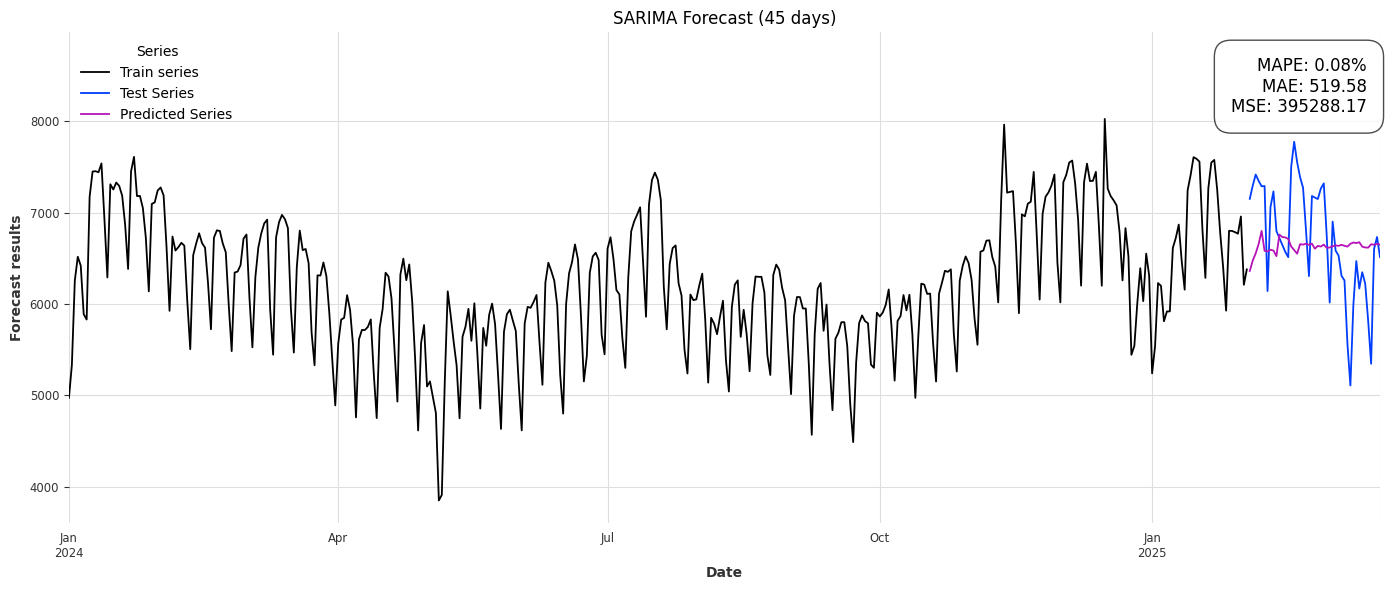

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(test_size)

visualize_forecast(train_series, test_series, sarima_forecast, start ='2024-01-01', title="SARIMA Forecast (45 days)")

### `Prophet`

22:04:00 - cmdstanpy - INFO - Chain [1] start processing
22:04:01 - cmdstanpy - INFO - Chain [1] done processing


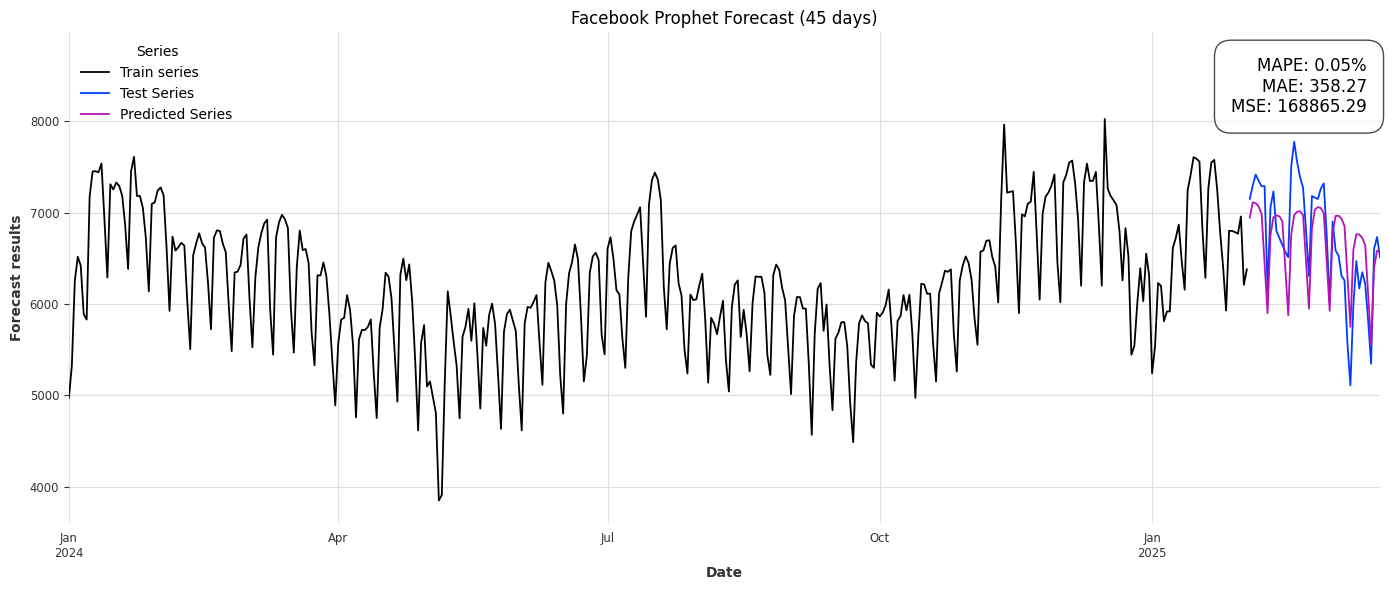

In [37]:
train_df_prophet = pd.DataFrame({
    'ds': train_series.index, 
    'y': train_series.values 
})

model = Prophet()
model.fit(train_df_prophet)

future = model.make_future_dataframe(periods=test_size, freq='d')
forecast = model.predict(future)
forecast_series = forecast.set_index("ds")["yhat"].loc[test_series.index]

visualize_forecast(train_series, test_series, forecast_series, start ='2024-01-01', title="Facebook Prophet Forecast (45 days)")

### `Amazon Chronos Bolt` 

In [32]:
chronos_model = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [ ]:
train_values = torch.tensor(train_series)
forecast = chronos_model.predict_quantiles(
    context=train_values,
    prediction_length=len(test_series)
)

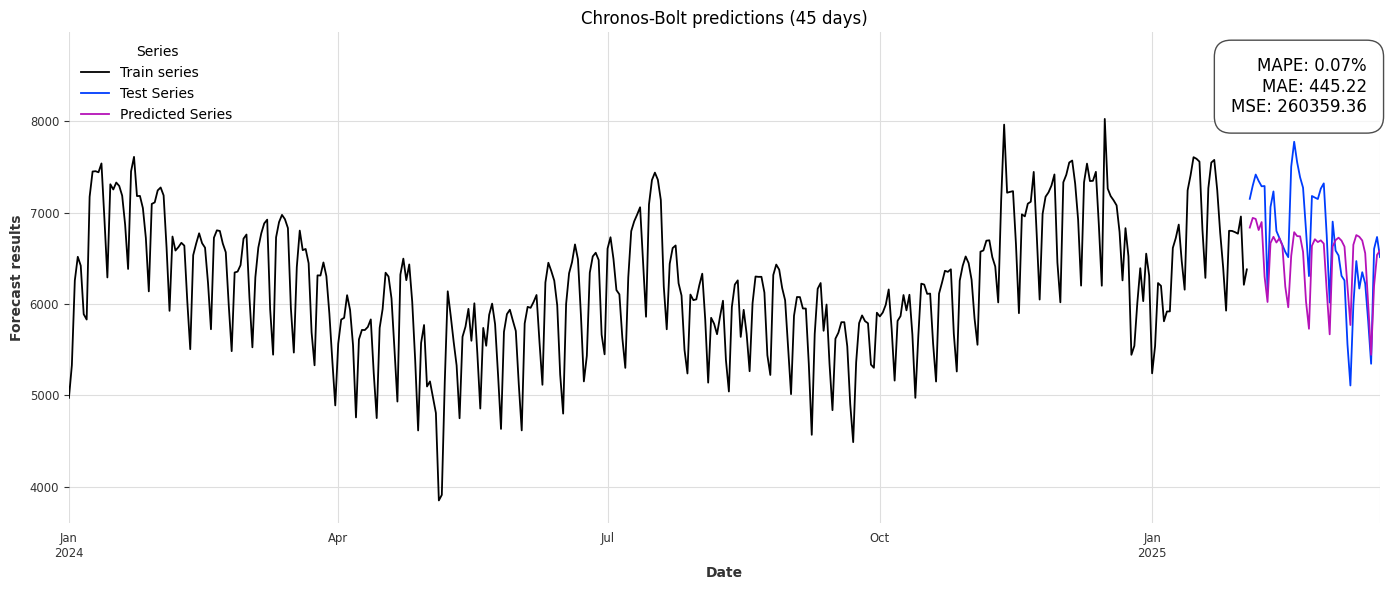

In [35]:
visualize_forecast(
    train_series=train_series,
    test_series=test_series,
    forecast_series=forecast_series,
    start ='2024-01-01',
    title="Chronos-Bolt predictions (45 days)"
)

### `Time-lagged regression model`

In [40]:
def create_lag_features(time_series: pd.Series, lags=12):
    """Create time-lagged features for the provided time series"""

    df = pd.DataFrame(time_series)

    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)
    
    return df

In [ ]:
lags = 12
time_lagged_df = create_lag_features(daily_df, lags)
time_lagged_df = time_lagged_df.dropna()
time_lagged_df.tail(10)

,Consumption,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
DateTime,,,,,,,,,,,,,
2025-03-10,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391,6016.166667,6747.166667,7319.590909,7262.416667,7148.500000
2025-03-11,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391,6016.166667,6747.166667,7319.590909,7262.416667
2025-03-12,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391,6016.166667,6747.166667,7319.590909
2025-03-13,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391,6016.166667,6747.166667
2025-03-14,6222.894737,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391,6016.166667
2025-03-15,5817.956522,6222.894737,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000,6901.217391
2025-03-16,5346.375000,5817.956522,6222.894737,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261,6584.250000
2025-03-17,6603.125000,5346.375000,5817.956522,6222.894737,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000,6530.478261
2025-03-18,6733.250000,6603.125000,5346.375000,5817.956522,6222.894737,6347.875000,6169.045455,6469.952381,5990.400000,5108.833333,5563.043478,6258.125000,6308.250000


In [42]:
train_df, test_df = time_lagged_df[:-test_size], time_lagged_df[-test_size:]

In [43]:
train_df, test_df = time_lagged_df[:-test_size], time_lagged_df[-test_size:]
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [44]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = []
current_input = X_test.iloc[0].values.reshape(1, -1)

for _ in range(len(y_test)):
    prediction = model.predict(current_input)[0]
    y_pred.append(prediction)

    # Slide the window: Remove the oldest lag, add the latest prediction
    current_input = pd.concat([pd.Series([prediction]), pd.Series(current_input[0][:-1])]).values.reshape(1, -1)


In [ ]:
forecast_series = pd.Series(y_pred, index=test_series.index)

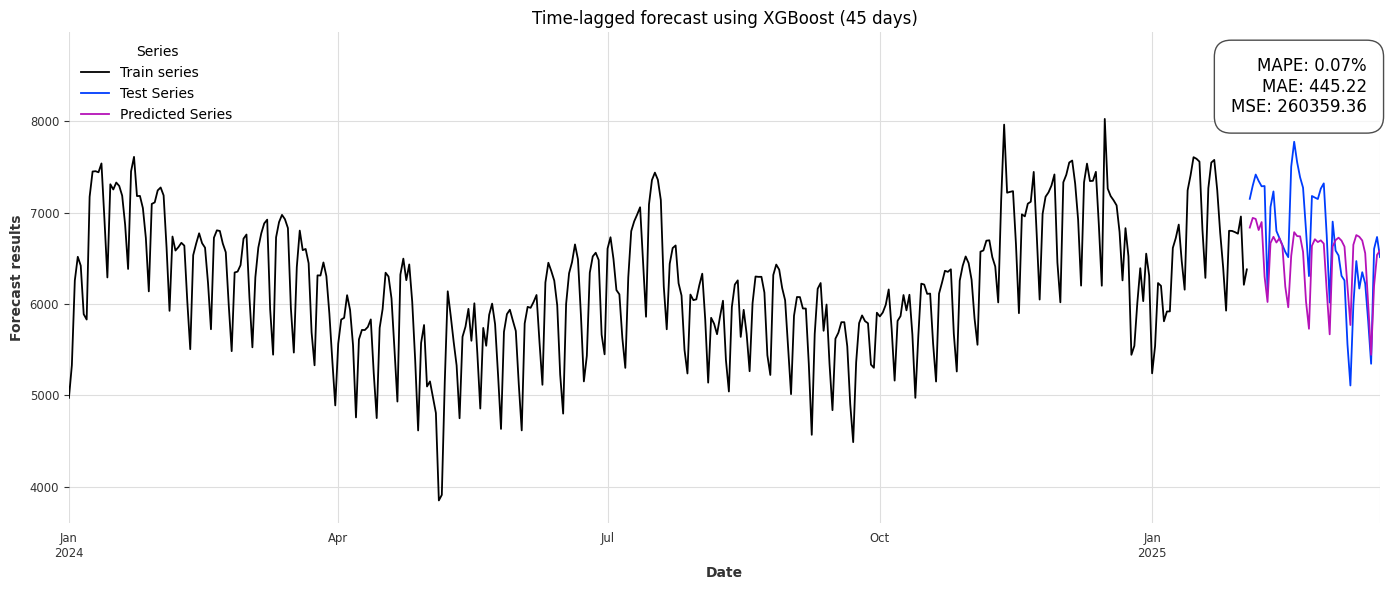

In [47]:
visualize_forecast(
    train_series,
    test_series,
    forecast_series,
    start ='2024-01-01',
    title="Time-lagged forecast using XGBoost (45 days)"
)

### Summary of Model Performance

| Model                  | MAE (Mean Absolute Error) | MAPE (Mean Absolute % Error) | MSE       |
| ---------------------- | ------------------------- | ---------------------------- | --------- |
| SARIMAX                | 519                       | 0.08%                        | \~395,000 |
| Time-lagged Regression | 445                       | 0.07%                        | \~260,300 |
| Prophet                | 358                       | 0.05%                        | \~168,800 |
| Chronos-Bolt           | 445                       | 0.07%                        | \~260,000 |

All models were tested on a daily aggregated electricity consumption dataset containing over 54,000 hourly records aggregated by day. Prophet achieved the best accuracy 
with the lowest MAE and MSE, effectively capturing trends and seasonality. Time-lagged Regression and Chronos-Bolt showed competitive results, leveraging past consumption values and adaptive modeling respectively.


